# Ejercicio 1

El objetivo de este ejercicio es que el estudiante utilice Deep Neural Networks, específicamente la arquitectura LTSM para realizar forecast. Así mismo, el estudiante comenzará a analizar de forma objetiva series de tiempo.

## Ejercicio 1.1 

Ejecute y analice el siguiente código

In [44]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
import math
import datetime

In [45]:
# CONSTANTES 
LAG = 12  # lagged values
HIDDEN1 = 60  # Nro. neuronas de la primera capa
HIDDEN2 = 60
HIDDEN3 = 60
HIDDEN4 = 60
EPOCHS = 100  # número de epocas para entrenamiento. Si se demora mucho tiempo, baje el número de esta variable
REDUCIR_DATASET = False  # si el dataset toma mucho tiempo en entrenarse, habilite esta variable

In [46]:
df = pd.read_csv("monthly-milk-production-pounds.csv", index_col=0, parse_dates=[0])
df.sort_values('MonthlyMilk')
df['MonthlyMilk'].max()

969

In [47]:
len(df)

168

Ejecutar esta línea de código, solo si su computador es de bajas prestaciones y el entrenamiento del modelo se demora demasiado cuando se usa todo el dataset

In [48]:
# para hacer el dataset más pequeño y no tarde tanto tiempo el entrenamiento
if REDUCIR_DATASET:
    df = df[df.index >= "2010-01-01"]  

In [49]:
df.describe()

,MonthlyMilk
count,168.000000
mean,754.708333
std,102.204524
min,553.000000
25%,677.750000
50%,761.000000
75%,824.500000
max,969.000000


### Descripción gráfica del dataset

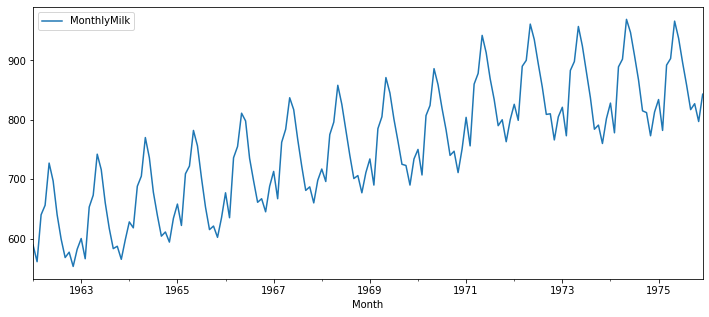

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
df.plot(ax=ax)

### Descomponiendo la serie de tiempo en trend+seasonal+resid

Este proceso se lo realiza en análisis de series de tiempo para entender si existen fenómenos como tendencias y efectos estacionales (tendencias que se repiten cada cierto tiempo)

Text(0, 0.5, 'Residuos')

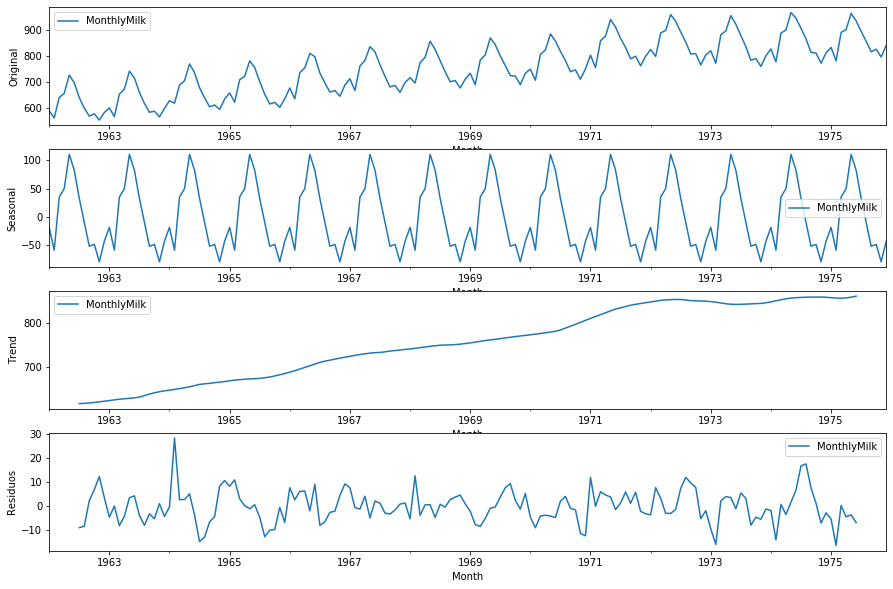

In [51]:
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot
result = seasonal_decompose(df, model='additive')

fig, ax = plt.subplots(4, 1, figsize=(15, 10))

result.observed.plot(ax=ax[0])
ax[0].set_ylabel("Original")

result.seasonal.plot(ax=ax[1])
ax[1].set_ylabel("Seasonal")

result.trend.plot(ax=ax[2])
ax[2].set_ylabel("Trend")

result.resid.plot(ax=ax[3])
ax[3].set_ylabel("Residuos")

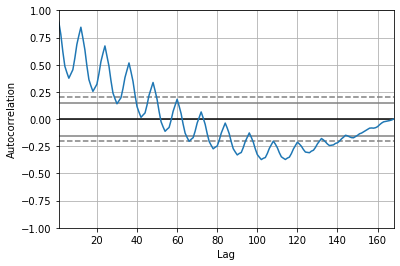

In [52]:
pd.plotting.autocorrelation_plot(df)

En base a la información de la serie de tiempo, no existe un componente de tendencia claro: el componente de tendencia es altamente volátil. Además, no existe un componente estacional definido; este componente varía en una forma indeterminada

### Datos para entrenamiento y prueba

In [53]:
train_data = df[:'1974-12-31']
test_data  = df['1974-12-31':]

print('Número de observaciones: %d' % (len(df)))
print('Dataset de entrenamiento:',train_data.shape)
print('Dataset de prueba:', test_data.shape)

Número de observaciones: 168
Dataset de entrenamiento: (156, 1)
Dataset de prueba: (12, 1)


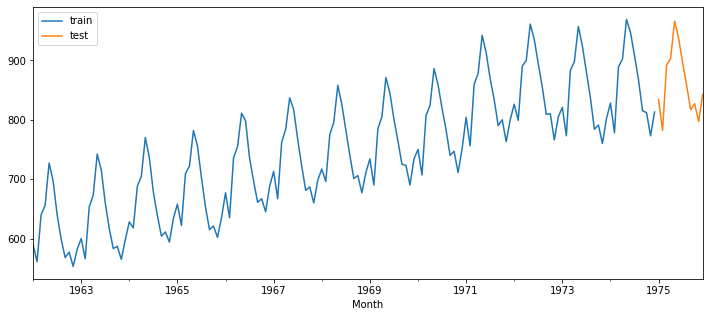

In [54]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
train_data.plot(ax=ax)
test_data.plot(ax=ax)
plt.legend(['train', 'test']);
plt.savefig('myfile.png')

En base a este gráfico:

- Como podría comparar los valores de prueba y los de entrenamiento: tendencia, amplitud, etc
- ¿Cree que es factible que un modelo pueda capturar las dinámicas intrínsecas de la serie de tiempo para predecir valores futuros acertadamente? ¿Por que?

### Normalizando y dividiendo los datos para entrenamiento y prueba

In [55]:
from sklearn.preprocessing import MinMaxScaler

# los datos son escalados en un rango de 0 y 1
scaler = MinMaxScaler(feature_range=(0,1))

train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)

In [56]:
# se actualiza el valor del dataframe con los valores normalizados
df['MonthlyMilk'] = np.concatenate([train_data_scaled, test_data_scaled])[:, 0]

In [57]:
def window(ds, lags):
    tmp_ind = ds.index.to_numpy()[lags:]
    for i in range(lags):
        tmp = ds.iloc[:, 0].shift(-(i+1))
        ds = pd.concat([ds, tmp], axis=1)
        
    ds = ds.dropna()
    ds.index = tmp_ind
        
    return ds

ndf = window(df, LAG)
train_data_scaled = ndf[:'1974-12-31'].to_numpy()
test_data_scaled  = ndf['1974-12-31':].to_numpy()

In [58]:
print('Observaciones: %d' % (len(ndf)))
print('Dataset de entrenamiento:',train_data_scaled.shape)
print('Dataset de prueba:', test_data_scaled.shape)

Observaciones: 156
Dataset de entrenamiento: (144, 13)
Dataset de prueba: (12, 13)


In [59]:
# se asignan los datos para entrenamiento y prueba
X_train, y_train = train_data_scaled[:, :-1], train_data_scaled[:, -1]
X_test, y_test = test_data_scaled[:, :-1], test_data_scaled[:, -1]

In [60]:
# reshaping
# 3D tensor with shape (batch_size, timesteps, input_dim).

# Keras adminte datos de entrada del tipo (batch_size, timesteps, input_dim)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(X_train.shape, y_train.shape)

(144, 12, 1) (144,)


## Creando y entrenando el modelo

In [61]:
# Creando el modelo

# initializing RNN
model = tf.keras.Sequential()

# adding 1st LSTM layer and some dropout regularization
model.add(tf.keras.layers.LSTM(units=HIDDEN1, input_shape=(X_train.shape[1], 1), return_sequences=True, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))

# adding 2nd LSTM layer and some dropout regularization
model.add(tf.keras.layers.LSTM(units=HIDDEN2, return_sequences=True))
model.add(tf.keras.layers.Dropout(0.2))

# adding 3rd LSTM layer and some dropout regularization
model.add(tf.keras.layers.LSTM(units=HIDDEN3, return_sequences=True))
model.add(tf.keras.layers.Dropout(0.2))

# adding 4th LSTM layer and some dropout regularization
model.add(tf.keras.layers.LSTM(units=HIDDEN4))
model.add(tf.keras.layers.Dropout(0.2))

# adding output layer
model.add(tf.keras.layers.Dense(units=1))

#compiling RNN
model.compile(loss='mean_squared_error', optimizer='adam')
# model.compile(loss='mean_absolute_percentage_error', optimizer='adam')

early_stopping = EarlyStopping(monitor='loss', patience=4)

# fitting RNN on training set
history = model.fit(X_train, y_train,
                    epochs=EPOCHS,
                    batch_size=32,
                    validation_split=0.3,
                    verbose=0,  # solo para efectos demostrativos
                    #callbacks=[early_stopping],
                    use_multiprocessing=True)

In [62]:
# cambia la forma del vector de prueba para que sea aceptado por el modelo
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# predice con las matrices de entrenamiento y prueba
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([y_test])

# calcula root mean squared error
#El Error cuadrado medio (MSE) o desviación cuadrada media (MSD) de un estimador mide el promedio de 
#cuadrados de error, es decir, la diferencia cuadrada media entre los valores estimados y el valor verdadero.
#Error medio para el data set de entrenamiento

trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Entrenamiento: %.2f RMSE' % (trainScore))

#Error medio para el data set de prueba
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Prueba: %.2f RMSE' % (testScore))


#R-cuadrado es una medida estadística de lo cerca que están los datos de la línea de regresión ajustada. 
#También se conoce como el coeficiente de determinación, o el coeficiente de determinación múltiple para la regresión múltiple. 

# calcula el r2
trainScore = r2_score(trainY[0], trainPredict[:,0])
print('Entrenamiento: %.2f R2' % (trainScore))

testScore = r2_score(testY[0], testPredict[:,0])
print('Prueba: %.2f R2' % (testScore))

Entrenamiento: 23.27 RMSE
Prueba: 20.74 RMSE
Entrenamiento: 0.94 R2
Prueba: 0.85 R2


### Resultados de la predicción

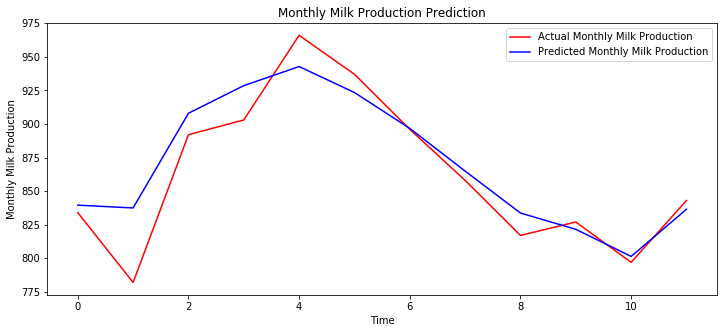

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))

ax.plot(testY[0], color = 'red', label ="Actual Monthly Milk Production")
ax.plot(testPredict, color='blue', label = 'Predicted Monthly Milk Production')
plt.title("Monthly Milk Production Prediction")
plt.xlabel('Time')
plt.ylabel('Monthly Milk Production')
plt.legend(loc='best')
plt.show()

### Resultados del entrenamiento

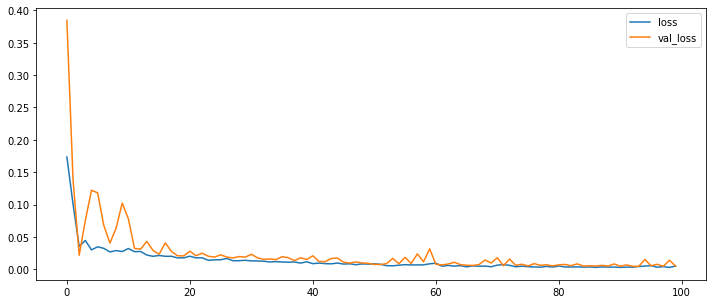

In [64]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.plot(history.history["loss"], label="loss")
ax.plot(history.history["val_loss"], label="val_loss")
plt.legend()
plt.show()

## Ejercicio 1.2

En base a los resultados de la predicción:

- ¿Los resultados son lo suficientemente aceptables para aplicar este modelo en predicción? ¿Por que?
- Durante el entrenamiento de la red, ¿Que realiza el `dropout`?

## Ejercicio 1.3

¿Puede mejorar de alguna manera los resultados de este problema? 

Ayuda: puede modificar la arquitectura de la red (agregar/quitar capas), no usar todos los datos de entrenamiento, transformaciones de datos, etc.

## Ejercicio 1.4

Utilizar ahora SVR para el mismo problema. ¿Los resultados son mejores o peores?

## Ejercicio 1.5

Comparar los resultados anteriores con los resultados de un modelo persistente. Un modelo persistente en términos de forecast es un modelo que predice el valor futuro repitiendo lo que sucede actualmente; es decir, $F(x_{t+1})=x_t$. 

- Habiendo probado varios modelos, ¿Que modelo le parece mejor? ¿Por que?